<a href="https://colab.research.google.com/github/MagsMagnoli/ieee-cis-fraud-detection/blob/master/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Kaggle

In [0]:
# auth kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# get kaggle datasets
import os
os.environ['KAGGLEUSERNAME'] = "x" # username from the json file 
os.environ['KAGGLEKEY'] = "x" # key from the json file
!kaggle competitions download ieee-fraud-detection # api copied from kaggle

In [0]:
# unzip data
!unzip train_identity.csv.zip
!unzip train_transaction.csv.zip
!unzip test_identity.csv.zip
!unzip test_transaction.csv.zip

# Setup Environment

In [0]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

%matplotlib inline

In [0]:
# reduce memory usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [0]:
# load data
%%time
warnings.simplefilter('ignore')
files = ['test_identity.csv', 
         'test_transaction.csv',
         'train_identity.csv',
         'train_transaction.csv']

def load_data(file):
    return reduce_mem_usage(pd.read_csv(file))

with multiprocessing.Pool() as pool:
    test_identity, test_transaction, train_identity, train_transaction = pool.map(load_data, files)

Memory usage of dataframe is 44.39 MB
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 9.86 MB
Decreased by 77.8%
Memory usage after optimization is: 10.02 MB
Decreased by 77.8%
Memory usage of dataframe is 1519.24 MB
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
CPU times: user 709 ms, sys: 1.18 s, total: 1.88 s
Wall time: 1min 55s


In [0]:
# merge dfs
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

print(f'The training data contains {train.shape[0]} rows and {train.shape[1]} columns')
print(f'The testing data contains {test.shape[0]} rows and {test.shape[1]} columns')

The training data contains 590540 rows and 434 columns
The testing data contains 506691 rows and 433 columns


# Visualize Data

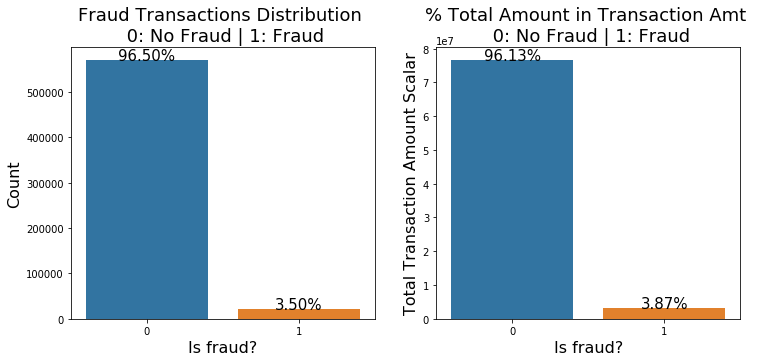

In [0]:
# fraud transactions distribution
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float)
total = len(train_transaction)
total_amt = train_transaction.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_tr = sns.countplot(x='isFraud', data=train_transaction)
plot_tr.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr.set_xlabel("Is fraud?", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

# % total amount in transaction amount    
percent_amt = (train_transaction.groupby(['isFraud'])['TransactionAmt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=percent_amt)
plot_tr_2.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr_2.set_xlabel("Is fraud?", fontsize=16)
plot_tr_2.set_ylabel('Total Transaction Amount Scalar', fontsize=16)
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15)

# Process Data

## Remove columns with too many missing values

In [0]:
missing_values = train.notnull().sum().sort_values(ascending=False)
missing_per = ((missing_values)/len(train)) * 100
pd.concat([missing_values, missing_per], keys=['Missing Values', 'Not Missing %'], axis=1)

,Missing Values,Not Missing %
TransactionID,590540,100.000000
C9,590540,100.000000
C1,590540,100.000000
C2,590540,100.000000
C3,590540,100.000000
C4,590540,100.000000
C5,590540,100.000000
C6,590540,100.000000
card1,590540,100.000000
C8,590540,100.000000


In [0]:
def delete_too_much_missing_data(data):
    too_much_null_cols = [col for col in data.columns if data[col].isnull().sum()/data.shape[0]>0.8]
    return too_much_null_cols

In [0]:
# delete columns in train and test that have too much missing data in test
new_train = train.drop(delete_too_much_missing_data(train), axis = 1)
new_test = test.drop(delete_too_much_missing_data(train), axis = 1)

In [0]:
# shape
print(new_train.shape)
print(new_test.shape)

(590540, 360)
(506691, 359)


## Encode categorical features

In [0]:
def find_categorical(dataframe):
  # Categorical boolean mask
  categorical_feature_mask = dataframe.dtypes=="category"
  # filter categorical columns using mask and turn it into a list
  categorical_cols = dataframe.columns[categorical_feature_mask].tolist()
  return categorical_cols

In [0]:
categorical = find_categorical(new_train)

In [0]:
# def get_dummies(dataframe):
  # Get dummies
  X = pd.get_dummies(dataframe, prefix_sep='_', drop_first=True)
  return X

In [0]:
# # replace data by encoded data
new_train = get_dummies(new_train)
new_test = get_dummies(new_test)

In [0]:
# head
print(new_train.head())
print(new_test.head())

   TransactionID  isFraud  ...  DeviceType                     DeviceInfo
0        2987000        0  ...         NaN                            NaN
1        2987001        0  ...         NaN                            NaN
2        2987002        0  ...         NaN                            NaN
3        2987003        0  ...         NaN                            NaN
4        2987004        0  ...      mobile  SAMSUNG SM-G892A Build/NRD90M

[5 rows x 360 columns]
   TransactionID  TransactionDT  TransactionAmt  ... id_38  DeviceType  DeviceInfo
0        3663549       18403224       31.953125  ...   NaN         NaN         NaN
1        3663550       18403263       49.000000  ...   NaN         NaN         NaN
2        3663551       18403310      171.000000  ...   NaN         NaN         NaN
3        3663552       18403310      285.000000  ...   NaN         NaN         NaN
4        3663553       18403317       67.937500  ...   NaN         NaN         NaN

[5 rows x 359 columns]


In [0]:
# drop categorical values
new_train = new_train.drop(find_categorical(new_train), axis = 1)
new_test = new_test.drop(find_categorical(new_test), axis = 1)

In [0]:
# head
print(new_train.head())
print(new_test.head())

   TransactionID  isFraud  TransactionDT  ...  id_17  id_19  id_20
0        2987000        0          86400  ...    NaN    NaN    NaN
1        2987001        0          86401  ...    NaN    NaN    NaN
2        2987002        0          86469  ...    NaN    NaN    NaN
3        2987003        0          86499  ...    NaN    NaN    NaN
4        2987004        0          86506  ...  166.0  542.0  144.0

[5 rows x 334 columns]
   TransactionID  TransactionDT  TransactionAmt  ...  id_17  id_19  id_20
0        3663549       18403224       31.953125  ...    NaN    NaN    NaN
1        3663550       18403263       49.000000  ...    NaN    NaN    NaN
2        3663551       18403310      171.000000  ...    NaN    NaN    NaN
3        3663552       18403310      285.000000  ...    NaN    NaN    NaN
4        3663553       18403317       67.937500  ...    NaN    NaN    NaN

[5 rows x 333 columns]


## Replace numerical missing values

In [0]:
# replace na values
new_train = new_train.fillna(-9999)
new_test = new_test.fillna(-9999)

# Build Logistic Regression Model

In [0]:
X_train = new_train.drop("isFraud", axis = 1)
y_train = new_train["isFraud"]

In [0]:
# Split the data into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [0]:
# create model
model = LogisticRegression(verbose=1,solver='sag').fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 141 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


In [0]:
# predict
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
parameters = model.coef_

# Visualize Predictions

## Plot confusion matrix

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[113911      0]
 [  4197      0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


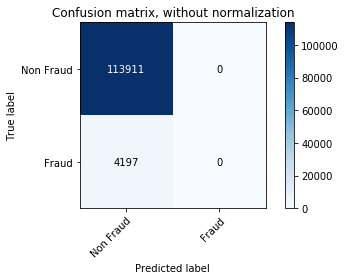

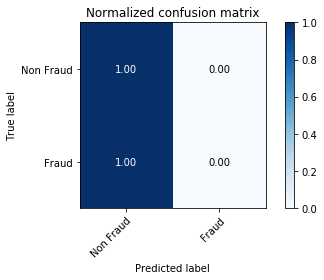

In [0]:
np.set_printoptions(precision=2)

# Defined predictions classes
class_names = ["Non Fraud", "Fraud"]

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()